In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 
EPOCHS_BASE = 50 #or 100
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder =  "./MovieReviews/"

### Load Data and preprocess

In [4]:
class_type = 4
def continous_2_cat(data):
    if data == -1:
        return -1
    if class_type ==3:
        if data <= 0.4:
            return 0
        elif data < 0.7:
            return 1
        else:
            return 2
    elif class_type == 4:
        if data <= 0.3:
            return 0
        elif data <= 0.5:
            return 1
        elif data <= 0.7:
            return 2
        else:
            return 3

In [7]:
##stratified range..
limits = [0]
pos_values = np.unique(targets_train)

N = targets_train.shape[0]
splits = 7 #5 ,7,8
acum_split = []
data_by_split = N/(splits) #minimum data on split
print("Minimum data on split: ",data_by_split)

for i in range(splits-1):
    if i != len(limits)-1:
        break
    upper_values = pos_values[pos_values>=limits[i]]
    for value in upper_values: #find the upper limit
        range_v = (limits[i] <= targets_train ) & (targets_train < value)
        if np.sum(range_v) >= data_by_split:
            limits.append(value)
            acum_split.append(np.sum(range_v))
            break
range_v = (limits[-1] <= targets_train ) & (targets_train <=1)
limits.append(np.max(pos_values)+0.1)
acum_split.append(np.sum(range_v))
limits = np.asarray(limits)

print("Splits obtained: ",len(acum_split))
print("Splits obtained ammount: ",acum_split)

def continous_2_cat(data):
    if data == -1:
        return -1
    return np.where(limits <= data )[0][-1]
limits

Minimum data on split:  214.0
Splits obtained:  6
Splits obtained ammount:  [387, 277, 252, 287, 215, 80]


array([0.  , 0.41, 0.51, 0.61, 0.71, 0.86, 1.1 ])

In [8]:
from keras import preprocessing
def read_texts(filename):
    f = open(filename)
    data = [line.strip() for line in f]
    f.close()
    return data

texts_train = read_texts(folder+"texts_train.txt")
targets_train = np.loadtxt(folder+"ratings_train.txt")
Z_train = np.asarray(list(map(continous_2_cat,targets_train )))

texts_test = read_texts(folder+"texts_test.txt")
targets_test = np.loadtxt(folder+"ratings_test.txt")
Z_test = np.asarray(list(map(continous_2_cat,targets_test )))

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 1498
Num. test texts:  3508


In [9]:
MAX_NB_WORDS = 40000 #probar cambiara 10mil o 2mil
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

(-100, 40000)

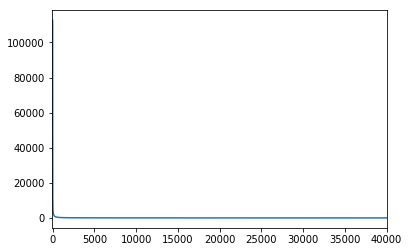

In [8]:
aux = np.asarray(list(tokenizer.word_counts.values()))
plt.plot(np.sort(aux)[::-1])
plt.xlim(-100,MAX_NB_WORDS)

In [10]:
lens = list(map(len,sequences_train))
max_L = np.max(lens)
print("Real max: ",max_L)
max_L = 1000 #Rodrigues
print("Used max: ",max_L)

X_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_L,dtype='int32', value=0,padding='pre')
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
print('Shape of train tensor:', X_train.shape)

Real max:  1384
Used max:  1000
Shape of train tensor: (1498, 1000)


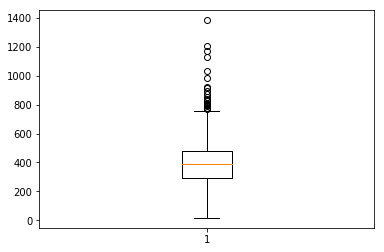

In [8]:
plt.boxplot(lens)
plt.show()

In [11]:
GLOVE_DIR = "../Deep Learning from Crowds/MovieReviews/glove.6B/"
embeddings_index = {}
with open(GLOVE_DIR + 'glove.6B.300d.txt') as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
EMBEDDING_DIM = 300
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i <= MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab), EMBEDDING_DIM))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
del embeddings_index, sorted_x, tokenizer
gc.collect()

Preparing embedding matrix.


7

### Load annotations / Generate

In [12]:
from code.representation import *
from code.utils import *

print("Loading AMT data...")
answers = pd.read_csv(folder+"answers.txt", header=None, delimiter=" ").as_matrix()
answers = answers[:,:-1]
answers[answers == 1.1] = 1.
answers[answers == -0.1] = 0.

y_obs = np.empty_like(answers)
for i in range(answers.shape[0]):
    y_obs[i] = list(map(continous_2_cat, answers[i]))
y_obs = y_obs.astype('int16')
N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Shape (data,annotators):  (1498, 135)
Classes:  6


In [17]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

(1000, 2547)

In [30]:
np.savetxt(folder+"answers_v2.txt",new_annotations, delimiter=",", fmt="%i")

In [ ]:
##  volver a pensar mejor lo de abajo..

In [13]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.9741379 , 0.02586207, 0.        , 0.        , 0.        ,
         0.        ],
        [0.38247013, 0.52988046, 0.08764941, 0.        , 0.        ,
         0.        ],
        [0.03070175, 0.32894737, 0.5745614 , 0.06578948, 0.        ,
         0.        ],
        [0.        , 0.03787879, 0.3560606 , 0.52272725, 0.08333334,
         0.        ],
        [0.        , 0.        , 0.01530612, 0.3877551 , 0.5102041 ,
         0.0867347 ],
        [0.        , 0.        , 0.        , 0.02777778, 0.2638889 ,
         0.7083333 ]],

       [[0.        , 0.03603604, 0.05405406, 0.01801802, 0.45945945,
         0.43243244],
        [0.        , 0.01298701, 0.03896104, 0.14285715, 0.36363637,
         0.44155845],
        [0.02857143, 0.01428571, 0.02857143, 0.1       , 0.3857143 ,
         0.44285715],
        [0.        , 0.04166667, 0.01388889, 0.04166667, 0.4027778 ,
         0.5       ],
        [0.        , 0.05084746, 0.05084746, 0.08474576, 0.37288135,
         0.44067797

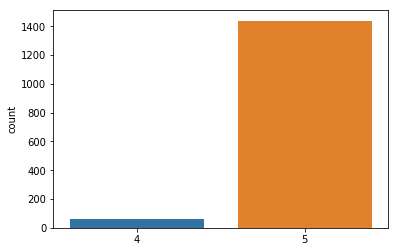

Minimum annotations in a example:  4
Maximum annotations in a example:  5
T data (expected value):  4.959946595460615
Graphics of T weights


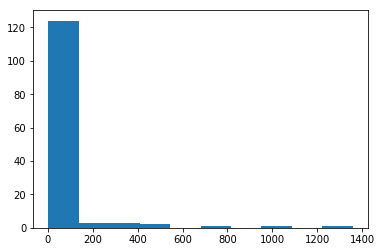

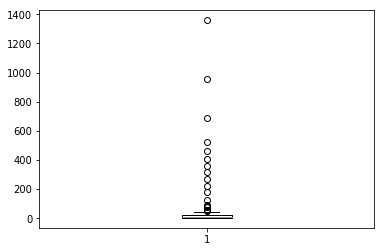

Minimum annotations by an annotator:  2
Maximum annotations by an annotator:  1359
Mean annotations by an annotator:  55.03703703703704


In [12]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [14]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, default_CNN_text

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=1e-3)

### Upper Bound Model -- ideal

In [12]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_CNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(X_train)
Z_test_pred = model_UB.predict_classes(X_test)

Trained IDeal Model, Epochs to converge = 45


In [15]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)

Representation for MV in 0.057011 sec
Representation for DS in 0.031474 sec
Estimation MV in 0.041759 sec


In [29]:
from keras.models import Sequential,Model
from keras.layers import *
def default_CNN_text(input_dim,output_dim,embed_M=[]):
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
    model.add(Conv1D(128, 5, activation='relu')) #kernel 5?
    model.add(BatchNormalization())
    model.add(MaxPooling1D(5))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(5))
    model.add(Dropout(0.5))
    
    model.add(GlobalAveragePooling1D())
    
    #model.add(Flatten())
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    
    model.add(Dense(output_dim, activation='softmax')) 
    return model

In [30]:
model_UB = default_CNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 300)         12000300  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 996, 128)          192128    
_________________________________________________________________
batch_normalization_9 (Batch (None, 996, 128)          512       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
batch_normalization_10 (Batc (None, 195, 128)          512       
__________

In [31]:
hist=model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2,callbacks=[ourCallback]
                  ,validation_data=(X_test,Z_test_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Train on 1498 samples, validate on 3508 samples
Epoch 1/50
 - 4s - loss: 1.8604 - val_loss: 1.9146
Epoch 2/50
 - 2s - loss: 1.6608 - val_loss: 2.0648
Epoch 3/50
 - 2s - loss: 1.5655 - val_loss: 1.8327
Epoch 4/50
 - 2s - loss: 1.4587 - val_loss: 1.8706
Epoch 5/50
 - 2s - loss: 1.3747 - val_loss: 1.7918
Epoch 6/50
 - 2s - loss: 1.2696 - val_loss: 1.7168
Epoch 7/50
 - 2s - loss: 1.1856 - val_loss: 1.5806
Epoch 8/50
 - 2s - loss: 1.0974 - val_loss: 1.5663
Epoch 9/50
 - 2s - loss: 0.9726 - val_loss: 1.5906
Epoch 10/50
 - 2s - loss: 0.8810 - val_loss: 1.6375
Epoch 11/50
 - 2s - loss: 0.7646 - val_loss: 1.7579
Epoch 12/50
 - 2s - loss: 0.6384 - val_loss: 1.6325
Epoch 13/50
 - 2s - loss: 0.5415 - val_loss: 1.5745
Epoch 14/50
 - 2s - loss: 0.4464 - val_loss: 1.6217
Epoch 15/50
 - 2s - loss: 0.3699 - val_loss: 1.8458
Epoch 16/50
 - 2s - loss: 0.3183 - val_loss: 1.9864
Epoch 17/50
 - 2s - loss: 0.2579 - val_loss: 1.7156
Epoch 18/50
 - 2s - loss: 0.2106 - val_loss: 1.7511
Epoch 19/50
 - 2s - loss:

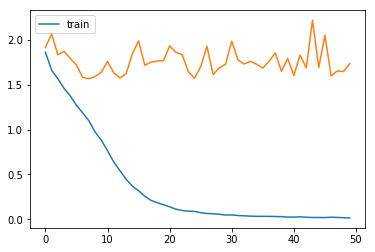

In [32]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [20]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2,callbacks=[ourCallback]
                     ,validation_data=(X_test,Z_test_onehot))
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

Train on 1498 samples, validate on 3508 samples
Epoch 1/50
 - 4s - loss: 2.7806 - val_loss: 2.0239
Epoch 2/50
 - 2s - loss: 2.4164 - val_loss: 2.1575
Epoch 3/50
 - 2s - loss: 2.2555 - val_loss: 2.0866
Epoch 4/50
 - 2s - loss: 2.1028 - val_loss: 2.0366
Epoch 5/50
 - 2s - loss: 2.0179 - val_loss: 1.9477
Epoch 6/50
 - 2s - loss: 1.9890 - val_loss: 1.8513
Epoch 7/50
 - 2s - loss: 1.9696 - val_loss: 1.8180
Epoch 8/50
 - 2s - loss: 1.9159 - val_loss: 1.8369
Epoch 9/50
 - 2s - loss: 1.9114 - val_loss: 1.8523
Epoch 10/50
 - 2s - loss: 1.8806 - val_loss: 1.8085
Epoch 11/50
 - 2s - loss: 1.8627 - val_loss: 1.7906
Epoch 12/50
 - 2s - loss: 1.8425 - val_loss: 1.7905
Epoch 13/50
 - 2s - loss: 1.8160 - val_loss: 1.8110
Epoch 14/50
 - 2s - loss: 1.7936 - val_loss: 1.8494
Epoch 15/50
 - 2s - loss: 1.8474 - val_loss: 1.8286
Epoch 16/50
 - 2s - loss: 1.8153 - val_loss: 1.8195
Epoch 17/50
 - 2s - loss: 1.7671 - val_loss: 1.8435
Epoch 18/50
 - 2s - loss: 1.7757 - val_loss: 1.8913
Epoch 19/50
 - 2s - loss:

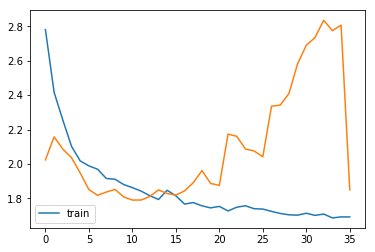

In [21]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [15]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.071657 sec
Representation for DS in 0.039089 sec
Estimation MV in 0.000891 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -7095.12631284214
2 	 -6559.673015593842 	0.1106	0.283549	0.075468
3 	 -6478.046699427695 	0.0185	0.185442	0.012444
4 	 -6459.050565117801 	0.0111	0.145406	0.002932
5 	 -6452.410756051137 	0.0084	0.097956	0.001028
6 	 -6449.318081050317 	0.0066	0.069387	0.000479
7 	 -6447.423251273201 	0.0051	10416.717773	0.000294
8 	 -6446.112916016764 	0.0039	6944.488770	0.000203
9 	 -6445.2365954857805 	0.0030	3472.259033	0.000136
10 	 -6444.683650836357 	0.0025	3472.253906	0.000086
11 	 -6444.305954363064 	0.0022	0.024133	0.000059
Class marginals
[0.25 0.3  0.28 0.17]
Estimation for DS in 4.510044 sec


In [236]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.6381842456608812
ACC D&S on train: 0.6835781041388518


In [16]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(X_train)
Z_test_pred = model_mvsoft.predict_classes(X_test)

Trained model over soft-MV, Epochs to converge = 37


In [18]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(X_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(X_train)
Z_test_pred = model_mvhard.predict_classes(X_test)

Trained model over hard-MV, Epochs to converge = 50


In [20]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(X_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(X_train)
Z_test_pred = model_ds.predict_classes(X_test)

Trained model over D&S, Epochs to converge = 50


### Raykar Model (joint predict model)

In [22]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1498, 135, 4)


In [23]:
raykarMC = RaykarMC(max_L, y_obs_categorical.shape[-1], T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn text", embed=embedding_matrix)

logL_hists,i_r = raykarMC.multiples_run(15,X_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Initializing new EM...
Betas shape:  (135, 4, 4)
Q estimate shape:  (1498, 4)
Iter 1/50 
M step: done,  E step: done //  (in 5.17 sec)	logL: -7889.640	
Iter 2/50 
M step: done,  E step: done //  (in 1.37 sec)	logL: -7325.240	Tol1: 0.07154	Tol2: 0.11948	
Iter 3/50 
M step: done,  E step: done //  (in 1.34 sec)	logL: -7043.740	Tol1: 0.03843	Tol2: 0.08693	
Iter 4/50 
M step: done,  E step: done //  (in 1.34 sec)	logL: -7072.470	Tol1: 0.00408	Tol2: 0.03993	
Iter 5/50 
M step: done,  E step: done //  (in 1.39 sec)	logL: -6800.264	Tol1: 0.03849	Tol2: 0.03398	
Iter 6/50 
M step: done,  E step: done //  (in 1.34 sec)	logL: -6917.506	Tol1: 0.01724	Tol2: 0.01830	
Finished training
Initializing new EM...
Betas shape:  (135, 4, 4)
Q estimate shape:  (1498, 4)
Iter 1/50 
M step: done,  E step: done //  (in 4.00 sec)	logL: -7599.112	
Iter 2/50 
M step: done,  E step: done //  (in 1.30 sec)	logL: -7097.563	Tol1: 0.06600	Tol2: 0.11099	
Iter 3/50 
M step: done,  E step: done //  (in 1.30 sec)	logL: -70

In [24]:
Z_train_p = raykarMC.get_predictions(X_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_p = raykarMC.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [27]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [28]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups

#get our representation 
r_obs = set_representation(y_obs,"repeat")
confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[4 0 0 1]
 [3 0 2 0]
 [4 0 0 1]
 ...
 [0 0 0 5]
 [0 0 1 4]
 [0 0 2 3]]
shape: (1498, 4)


Normalized entropy (0-1) of repeats annotations: 0.4942555201452063


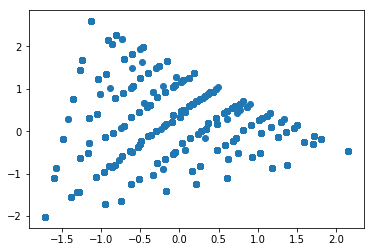

In [29]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.005395 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (1498, 4)
Betas:  (5, 4, 4)
Q estimate:  (1498, 4, 5, 4)
Iter 1/0
M step: done,  E step: done //  (in 2.28 sec)	logL: -10121.969	
Finished training!


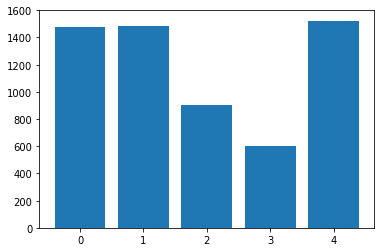

<BarContainer object of 5 artists>

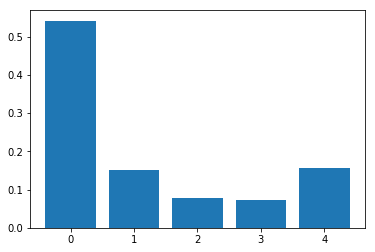

In [32]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 

gMixture_Global.define_model("default cnn text", embed=embedding_matrix)

logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [ ]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
uniform = True
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("default cnn text", embed=embedding_matrix)
        
        if uniform:
            #to uniform groups...
            gMixture_Global.define_priors("laplace")
            gMixture_Global.define_priors(uniform_groups) 
        
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

In [ ]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [ ]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

In [29]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [30]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default cnn text", embed=embedding_matrix)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

logL_hists,i_r = gMixture_Global.multiples_run(15,X_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.004076 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1498, 4)
Betas:  (3, 4, 4)
Q estimate:  (1498, 4, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 4.51 sec)	logL: -10413.204	
Iter 2/50
M step: done,  E step: done //  (in 1.31 sec)	logL: -10402.117	Tol1: 0.00106	Tol2: 0.65243	Tol3: 0.08668	
Iter 3/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -10190.050	Tol1: 0.02039	Tol2: 0.36434	Tol3: 0.06084	
Iter 4/50
M step: done,  E step: done //  (in 1.34 sec)	logL: -10871.713	Tol1: 0.06689	Tol2: 0.48913	Tol3: 0.10914	
Iter 5/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -10203.869	Tol1: 0.06143	Tol2: 2.09467	Tol3: 0.07353	
Iter 6/50
M step: done,  E step: done //  (in 1.33 sec)	logL: -10040.944	Tol1: 0.01597	Tol2: 0.32415	Tol3: 0.00935	
Iter 7/50
M step: done,  E step: done //  (in 1.31 sec)	logL: -10152.942	Tol1: 0.01115	Tol2: 0.08673	Tol3: 0.00265	
Iter 8/50
M step: done,  E step: done /

M step: done,  E step: done //  (in 1.36 sec)	logL: -9792.346	Tol1: 0.00286	Tol2: 0.06756	Tol3: 0.00546	
Iter 21/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -9758.162	Tol1: 0.00349	Tol2: 0.09387	Tol3: 0.00665	
Iter 22/50
M step: done,  E step: done //  (in 1.38 sec)	logL: -9710.201	Tol1: 0.00491	Tol2: 0.04652	Tol3: 0.00458	
Iter 23/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9702.567	Tol1: 0.00079	Tol2: 0.06483	Tol3: 0.00525	
Iter 24/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -9612.219	Tol1: 0.00931	Tol2: 0.08185	Tol3: 0.00482	
Iter 25/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -9490.020	Tol1: 0.01271	Tol2: 0.10976	Tol3: 0.00174	
Iter 26/50
M step: done,  E step: done //  (in 1.32 sec)	logL: -9562.410	Tol1: 0.00763	Tol2: 0.10547	Tol3: 0.01659	
Iter 27/50
M step: done,  E step: done //  (in 1.33 sec)	logL: -9554.112	Tol1: 0.00087	Tol2: 0.08040	Tol3: 0.00821	
Iter 28/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9522.893	Tol1: 0.00

M step: done,  E step: done //  (in 1.37 sec)	logL: -9924.551	Tol1: 0.00197	Tol2: 0.10174	Tol3: 0.00356	
Iter 10/50
M step: done,  E step: done //  (in 1.32 sec)	logL: -9932.189	Tol1: 0.00077	Tol2: 0.03866	Tol3: 0.00230	
Iter 11/50
M step: done,  E step: done //  (in 1.32 sec)	logL: -9913.161	Tol1: 0.00192	Tol2: 0.05203	Tol3: 0.00400	
Iter 12/50
M step: done,  E step: done //  (in 1.34 sec)	logL: -9897.368	Tol1: 0.00159	Tol2: 0.03031	Tol3: 0.00741	
Iter 13/50
M step: done,  E step: done //  (in 1.39 sec)	logL: -9884.438	Tol1: 0.00131	Tol2: 0.03303	Tol3: 0.00128	
Iter 14/50
M step: done,  E step: done //  (in 1.34 sec)	logL: -9883.077	Tol1: 0.00014	Tol2: 0.06331	Tol3: 0.00099	
Iter 15/50
M step: done,  E step: done //  (in 1.30 sec)	logL: -9861.556	Tol1: 0.00218	Tol2: 0.04936	Tol3: 0.00417	
Iter 16/50
M step: done,  E step: done //  (in 1.34 sec)	logL: -9864.222	Tol1: 0.00027	Tol2: 0.02177	Tol3: 0.00087	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas 

In [31]:
Z_train_p = gMixture_Global.get_predictions(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

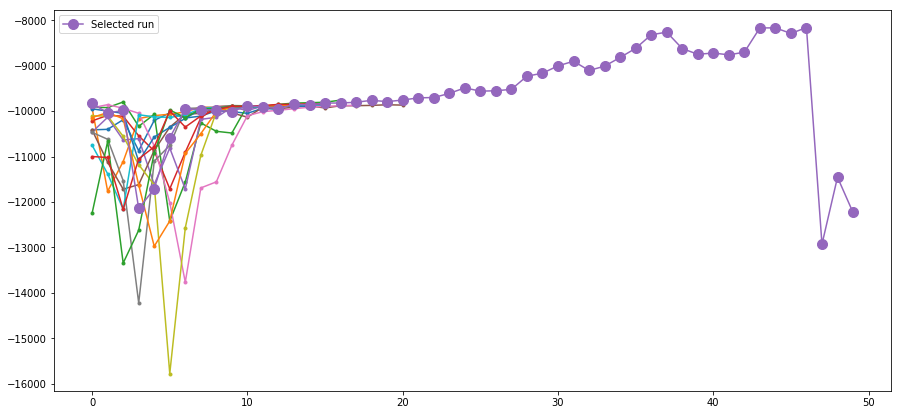

In [32]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [35]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (135, 135)


shape of annotator representation (T, R_t)= (135, 4)


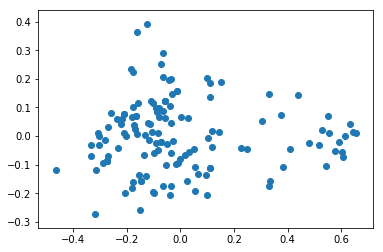

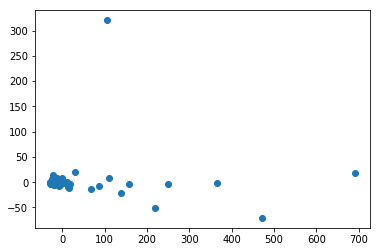

array([[235., 434., 481., 209.],
       [  0.,  16.,  45., 347.],
       [ 12.,  12.,   8.,   6.],
       [ 40.,  72.,  50.,  17.],
       [269., 344., 258.,  88.],
       [  0.,   2.,   3.,   1.],
       [ 34., 237., 328.,  86.],
       [  2.,   5.,   2.,   0.],
       [  0.,   2.,   3.,   3.],
       [ 52.,  81.,  88.,  47.],
       [ 33.,  22.,  34.,  38.],
       [ 96., 188., 165.,  76.],
       [127., 173., 136.,  27.],
       [  2.,   0.,   3.,   2.],
       [  2.,   1.,  11.,   1.],
       [ 14.,  28.,  33.,   1.],
       [  0.,   1.,   0.,   1.],
       [ 10.,  29.,  24.,  14.],
       [  2.,   6.,   9.,   1.],
       [  3.,   6.,   2.,   0.],
       [  0.,   2.,   2.,   0.],
       [  9.,   6.,   8.,   3.],
       [  0.,   1.,   2.,   0.],
       [  0.,   2.,   1.,   1.],
       [  3.,   1.,   0.,   1.],
       [  0.,   2.,   4.,   1.],
       [  0.,   0.,   4.,   0.],
       [  2.,   4.,  12.,   1.],
       [  1.,   1.,   2.,   1.],
       [ 85., 112., 111.,  51.],
       [  

In [36]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

#A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
A_rep = np.zeros((conf_mat.shape[0], Kl))
for t in range(A_rep.shape[0]):
    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [37]:
#different M_seted??
M_seted = 3

In [38]:
gMixture_Ind2 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind2.define_model("default cnn text", embed=embedding_matrix)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
#gMixture_Ind.define_model_group("keras_shallow", T, M_seted,embed=True, embed_M=A) #pareciera ser necesario pr-init

logL_hists,i_r = gMixture_Ind2.multiples_run(15,X_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.000827 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1498, 4)
Betas:  (3, 4, 4)
Q estimate:  (7430, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 3.97 sec)	logL: -9301.779	
Iter 2/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -9739.508	Tol1: 0.04706	Tol2: 0.15335	
Iter 3/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9789.401	Tol1: 0.00512	Tol2: 0.20906	
Iter 4/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -11484.365	Tol1: 0.17314	Tol2: 0.33124	
Iter 5/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -11378.355	Tol1: 0.00923	Tol2: 0.82975	
Iter 6/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -10166.178	Tol1: 0.10653	Tol2: 0.63534	
Iter 7/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9722.746	Tol1: 0.04362	Tol2: 0.57422	
Iter 8/50
M step: done,  E step: done //  (in 1.40

M step: done,  E step: done //  (in 1.37 sec)	logL: -10073.180	Tol1: 0.07739	Tol2: 0.39099	
Iter 7/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -11731.098	Tol1: 0.16459	Tol2: 0.57280	
Iter 8/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -12709.067	Tol1: 0.08337	Tol2: 0.59751	
Iter 9/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -15358.500	Tol1: 0.20847	Tol2: 7.01434	
Iter 10/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -11182.934	Tol1: 0.27187	Tol2: 1.25168	
Iter 11/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -9746.760	Tol1: 0.12843	Tol2: 0.57409	
Iter 12/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -10414.636	Tol1: 0.06852	Tol2: 0.12350	
Iter 13/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9650.271	Tol1: 0.07339	Tol2: 0.34902	
Iter 14/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9489.837	Tol1: 0.01662	Tol2: 0.17371	
Iter 15/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9485.277	Tol1: 0.00048	Tol

M step: done,  E step: done //  (in 1.36 sec)	logL: -9302.874	Tol1: 0.00708	Tol2: 0.10566	
Iter 18/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9217.538	Tol1: 0.00917	Tol2: 0.10555	
Iter 19/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9267.620	Tol1: 0.00543	Tol2: 0.05856	
Iter 20/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9134.070	Tol1: 0.01441	Tol2: 0.11993	
Iter 21/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9101.683	Tol1: 0.00355	Tol2: 0.06171	
Iter 22/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9030.744	Tol1: 0.00779	Tol2: 0.09862	
Iter 23/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -8983.262	Tol1: 0.00526	Tol2: 0.06173	
Iter 24/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -8892.301	Tol1: 0.01013	Tol2: 0.05733	
Iter 25/50
M step: done,  E step: done //  (in 1.36 sec)	logL: -9099.954	Tol1: 0.02335	Tol2: 0.05290	
Iter 26/50
M step: done,  E step: done //  (in 1.37 sec)	logL: -9180.367	Tol1: 0.00884	Tol2: 

In [39]:
Z_train_p = gMixture_Ind2.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind2.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind2.get_predictions_g(T_idx_unique) 

In [43]:
gMixture_Ind3 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("default cnn text", embed=embedding_matrix)

gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(15,X_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=15,max_iter=EPOCHS_BASE,tolerance=TOL) 

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000283 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *g* on 15 epochs... Done!
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1498, 4)
Betas:  (3, 4, 4)
Q estimate:  (7430, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 5.02 sec)	logL: -9590.202	
Iter 2/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -9293.979	Tol1: 0.03089	Tol2: 0.66405	
Iter 3/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9645.312	Tol1: 0.03780	Tol2: 0.17740	
Iter 4/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -9970.675	Tol1: 0.03373	Tol2: 0.32130	
Iter 5/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -14599.134	Tol1: 0.46421	Tol2: 0.46982	
Iter 6/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -11861.106	Tol1: 0.18755	Tol2: 1.00246	
Iter 7/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -9938.043	Tol1: 0.16213	Tol2: 1.11225	
Iter 8

M step: done,  E step: done //  (in 1.41 sec)	logL: -8787.599	Tol1: 0.00745	Tol2: 0.06902	
Iter 27/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -8776.901	Tol1: 0.00122	Tol2: 0.08553	
Iter 28/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -8648.634	Tol1: 0.01461	Tol2: 0.06256	
Iter 29/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -9134.584	Tol1: 0.05619	Tol2: 0.07696	
Iter 30/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -8699.896	Tol1: 0.04759	Tol2: 0.19288	
Iter 31/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -8601.002	Tol1: 0.01137	Tol2: 0.09165	
Iter 32/50
M step: done,  E step: done //  (in 1.40 sec)	logL: -8441.579	Tol1: 0.01854	Tol2: 0.09608	
Iter 33/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -8554.077	Tol1: 0.01333	Tol2: 0.08194	
Iter 34/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -8333.529	Tol1: 0.02578	Tol2: 0.15762	
Iter 35/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -8353.802	Tol1: 0.00243	Tol2: 

M step: done,  E step: done //  (in 1.44 sec)	logL: -9447.993	Tol1: 0.00153	Tol2: 0.07051	
Iter 16/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -9418.263	Tol1: 0.00315	Tol2: 0.09923	
Iter 17/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9373.518	Tol1: 0.00475	Tol2: 0.08710	
Iter 18/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9362.491	Tol1: 0.00118	Tol2: 0.07290	
Iter 19/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9331.420	Tol1: 0.00332	Tol2: 0.08101	
Iter 20/50
M step: done,  E step: done //  (in 1.43 sec)	logL: -9326.013	Tol1: 0.00058	Tol2: 0.05070	
Iter 21/50
M step: done,  E step: done //  (in 1.43 sec)	logL: -9299.362	Tol1: 0.00286	Tol2: 0.08544	
Iter 22/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -9280.155	Tol1: 0.00207	Tol2: 0.06742	
Iter 23/50
M step: done,  E step: done //  (in 1.53 sec)	logL: -9271.320	Tol1: 0.00095	Tol2: 0.03995	
Iter 24/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -9246.043	Tol1: 0.00273	Tol2: 

M step: done,  E step: done //  (in 4.84 sec)	logL: -9599.795	
Iter 2/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9764.218	Tol1: 0.01713	Tol2: 0.17404	
Iter 3/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -10414.330	Tol1: 0.06658	Tol2: 0.35307	
Iter 4/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -13966.922	Tol1: 0.34113	Tol2: 0.45325	
Iter 5/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -11199.189	Tol1: 0.19816	Tol2: 1.35043	
Iter 6/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -10268.174	Tol1: 0.08313	Tol2: 0.71831	
Iter 7/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9872.206	Tol1: 0.03856	Tol2: 0.53083	
Iter 8/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -9816.495	Tol1: 0.00564	Tol2: 0.06533	
Iter 9/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9747.302	Tol1: 0.00705	Tol2: 0.07569	
Iter 10/50
M step: done,  E step: done //  (in 1.41 sec)	logL: -9718.276	Tol1: 0.00298	Tol2: 0.07467	
Iter 11/50
M step: done

In [44]:
Z_train_p = gMixture_Ind3.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

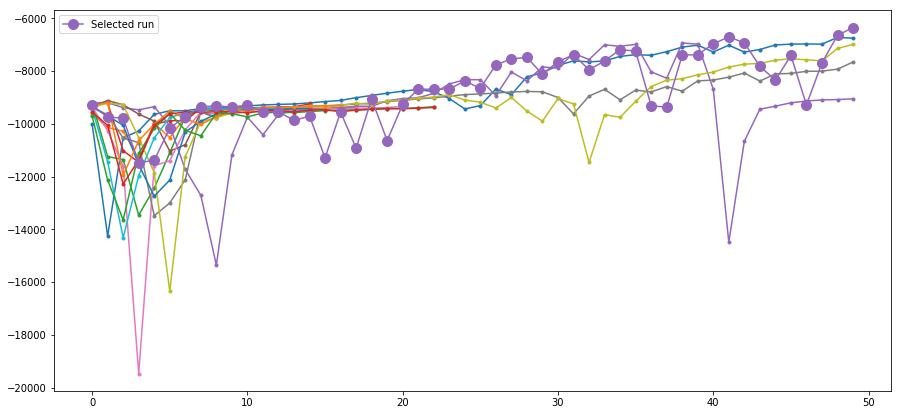

In [41]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [13]:
#Import it:
from code.evaluation import Evaluation_metrics

In [14]:
evaluate = Evaluation_metrics(model_UB,'keras',X_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result


Accuracy  F1 (micro)  F1 (macro)
0  All       1.0         1.0         1.0

Test
A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.5131      0.5131      0.4593

In [ ]:
#upper bound global confusion matrix..
prob_Yz = generate_confusionM(Z_train_pred, label_I.y_obs_repeat)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


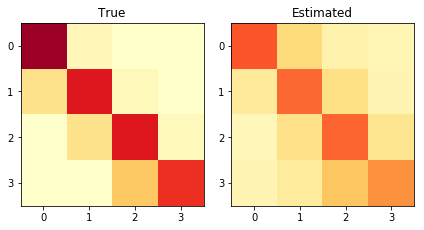

JS divergence: 0.1016	Norm Frobenius: 0.1462


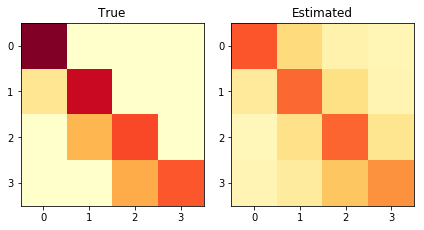

JS divergence: 0.1579	Norm Frobenius: 0.1664


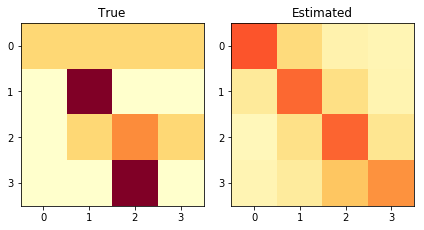

JS divergence: 0.2253	Norm Frobenius: 0.2731


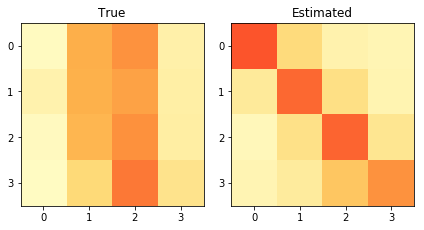

JS divergence: 0.1297	Norm Frobenius: 0.2238


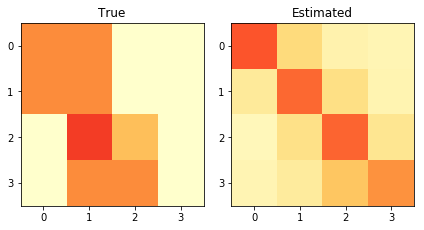

JS divergence: 0.2360	Norm Frobenius: 0.2496


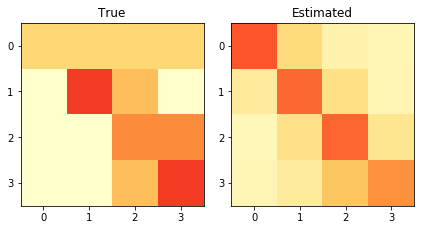

JS divergence: 0.1383	Norm Frobenius: 0.1690


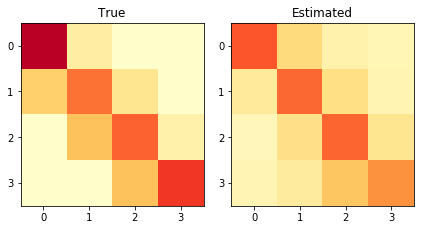

JS divergence: 0.0816	Norm Frobenius: 0.1144


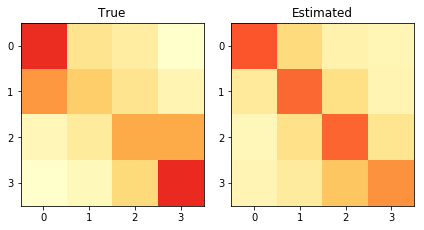

JS divergence: 0.0661	Norm Frobenius: 0.1512


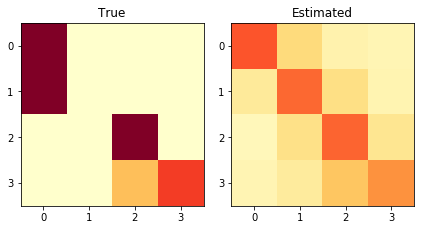

JS divergence: 0.3211	Norm Frobenius: 0.3197


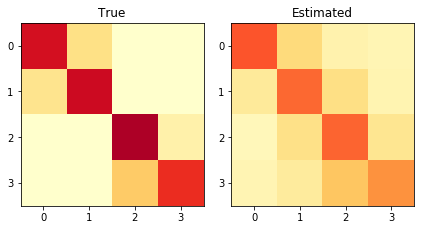

JS divergence: 0.1316	Norm Frobenius: 0.1558


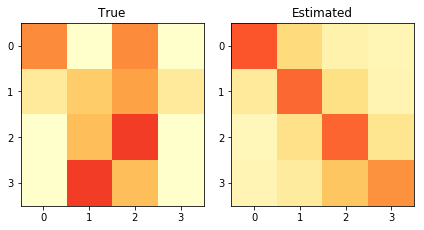

JS divergence: 0.2203	Norm Frobenius: 0.2441


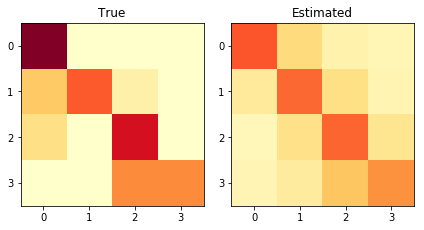

JS divergence: 0.1633	Norm Frobenius: 0.1695


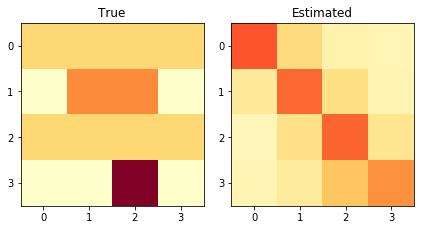

JS divergence: 0.2187	Norm Frobenius: 0.2738


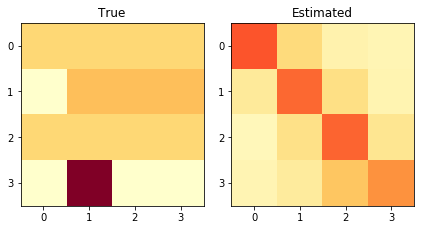

JS divergence: 0.2749	Norm Frobenius: 0.3148


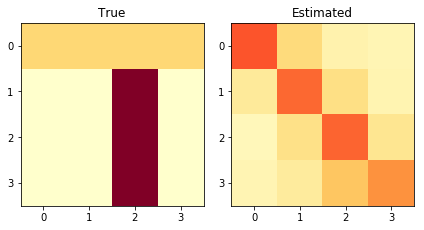

JS divergence: 0.3654	Norm Frobenius: 0.3670
Calculate confusion matrix on global version


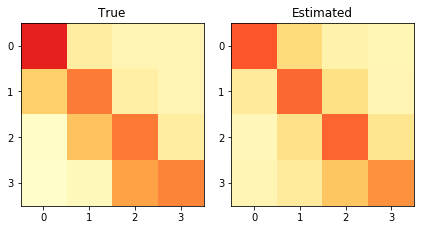

JS divergence: 0.0264	Norm Frobenius: 0.0803
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All    0.6128      0.6128      0.5914          0.2883       0.2687   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  
0       0.1975    0.1582     0.0803  0.0264

Test
A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.4108      0.4108      0.3263

In [17]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


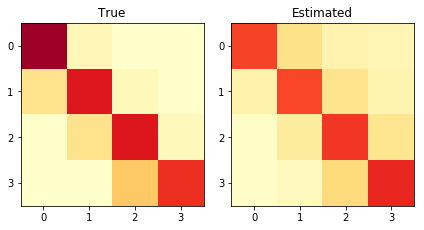

JS divergence: 0.0685	Norm Frobenius: 0.1105


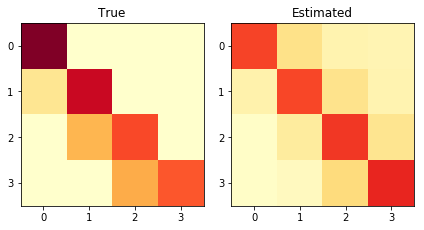

JS divergence: 0.1321	Norm Frobenius: 0.1541


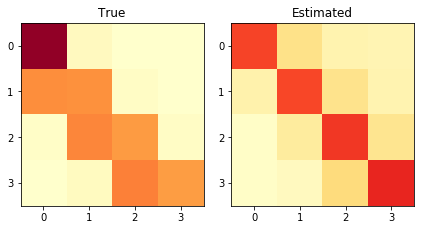

JS divergence: 0.1443	Norm Frobenius: 0.2151


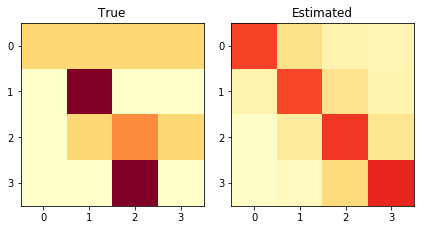

JS divergence: 0.2379	Norm Frobenius: 0.3129


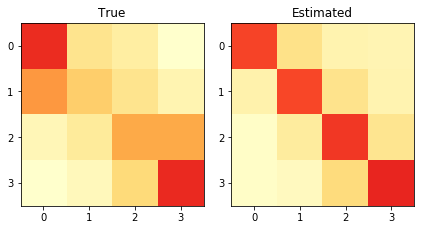

JS divergence: 0.0666	Norm Frobenius: 0.1596


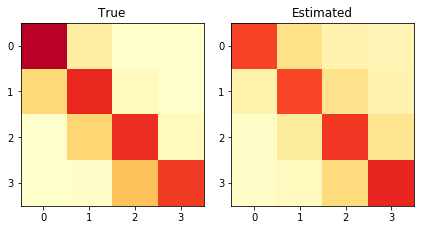

JS divergence: 0.0674	Norm Frobenius: 0.1030


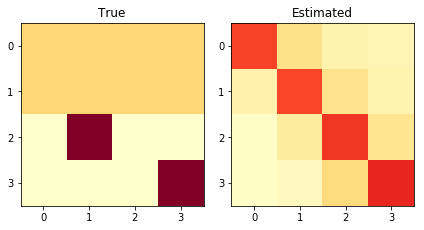

JS divergence: 0.2819	Norm Frobenius: 0.3365


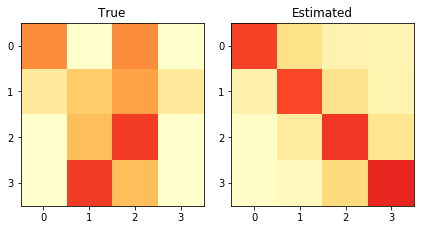

JS divergence: 0.2775	Norm Frobenius: 0.2997


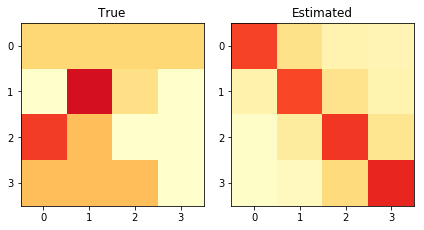

JS divergence: 0.3952	Norm Frobenius: 0.3485


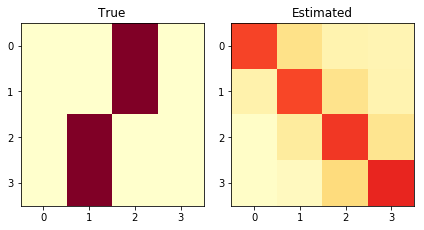

JS divergence: 0.7537	Norm Frobenius: 0.5674


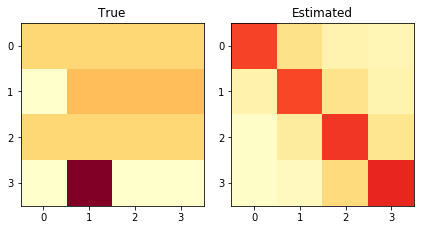

JS divergence: 0.3427	Norm Frobenius: 0.3690


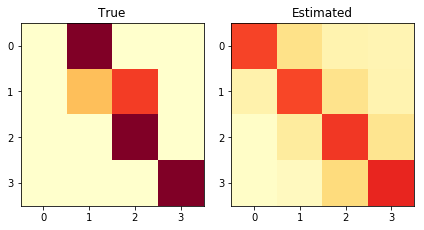

JS divergence: 0.2962	Norm Frobenius: 0.3273


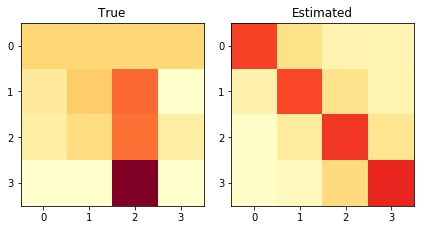

JS divergence: 0.2325	Norm Frobenius: 0.3225


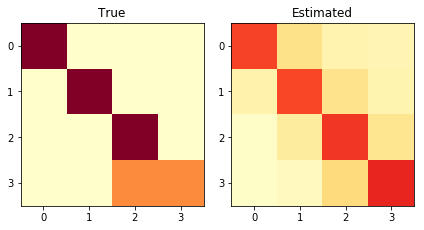

JS divergence: 0.1668	Norm Frobenius: 0.1974


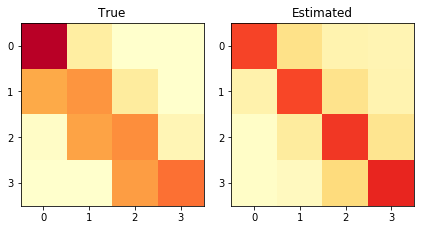

JS divergence: 0.0923	Norm Frobenius: 0.1600
Calculate confusion matrix on global version


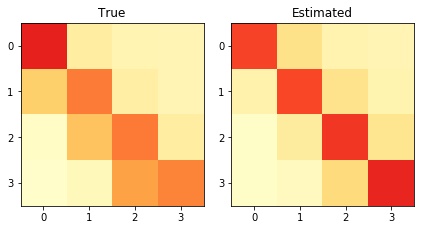

JS divergence: 0.0317	Norm Frobenius: 0.1123
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All    0.6382      0.6382      0.6464          0.3126       0.2914   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  
0        0.207    0.1572     0.1123  0.0317

Test
A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.4028      0.4028      0.3629

In [19]:
evaluate = Evaluation_metrics(model_mvhard,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


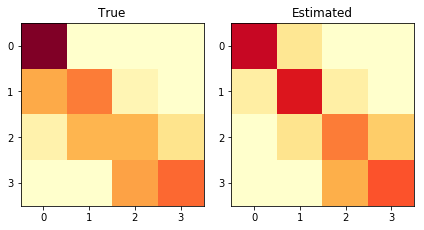

JS divergence: 0.0638	Norm Frobenius: 0.1318


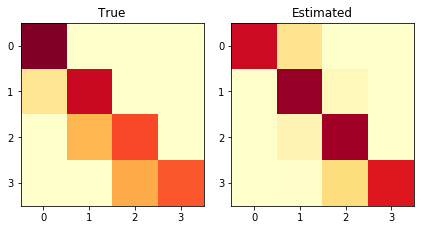

JS divergence: 0.0825	Norm Frobenius: 0.1428


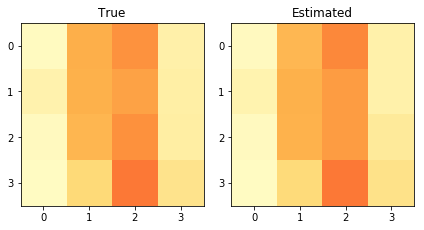

JS divergence: 0.0008	Norm Frobenius: 0.0166


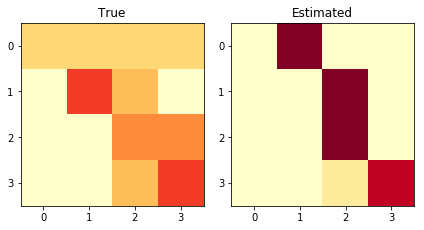

JS divergence: 0.3396	Norm Frobenius: 0.3721


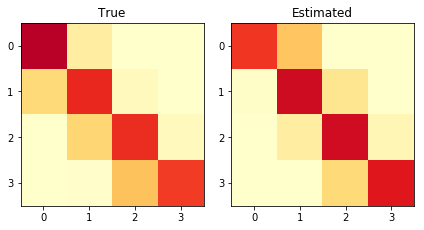

JS divergence: 0.0488	Norm Frobenius: 0.1111


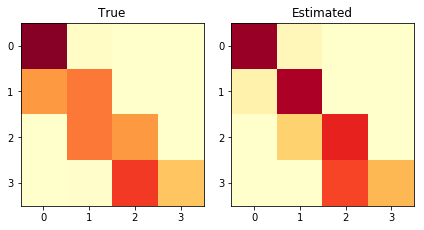

JS divergence: 0.0502	Norm Frobenius: 0.1621


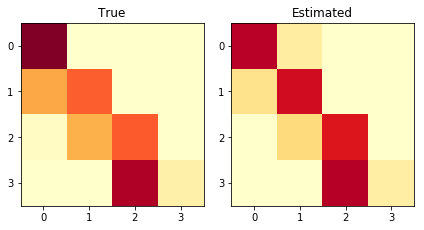

JS divergence: 0.0358	Norm Frobenius: 0.1065


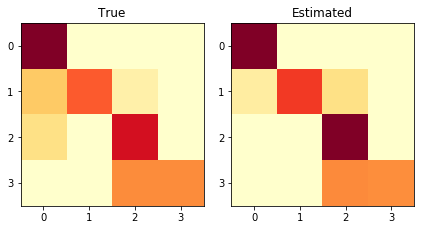

JS divergence: 0.0374	Norm Frobenius: 0.0889


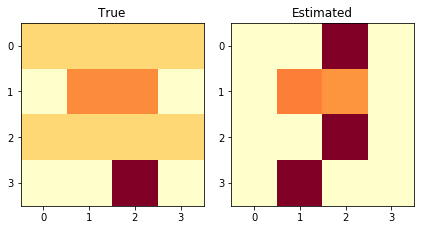

JS divergence: 0.5246	Norm Frobenius: 0.4678


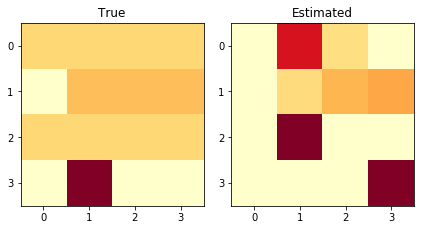

JS divergence: 0.4780	Norm Frobenius: 0.4458


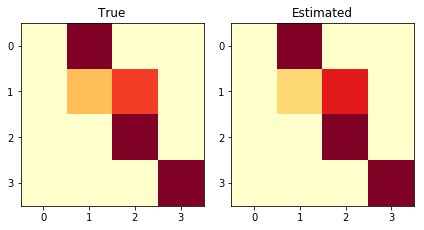

JS divergence: 0.0014	Norm Frobenius: 0.0281


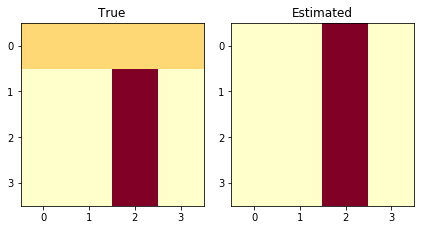

JS divergence: 0.1372	Norm Frobenius: 0.2165


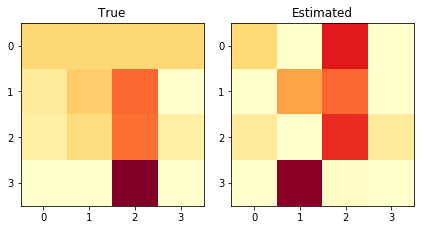

JS divergence: 0.3651	Norm Frobenius: 0.3871


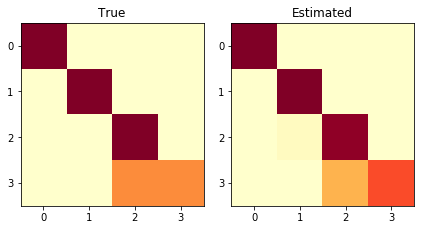

JS divergence: 0.0073	Norm Frobenius: 0.0477


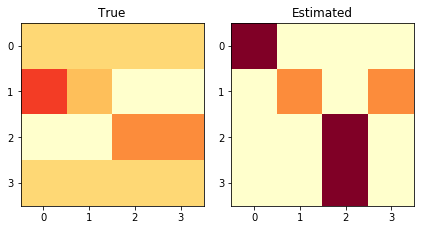

JS divergence: 0.5011	Norm Frobenius: 0.4125
Calculate confusion matrix on global version


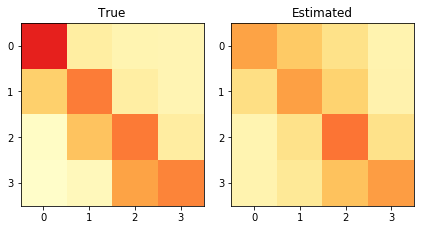

JS divergence: 0.0465	Norm Frobenius: 0.1208
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All    0.6903      0.6903       0.699          0.2496       0.2128   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  
0       0.1222    0.0587     0.1208  0.0465

Test
A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.4156      0.4156      0.4162

In [21]:
evaluate = Evaluation_metrics(model_ds,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


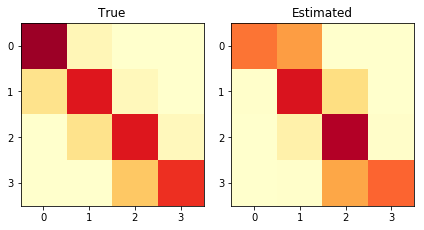

JS divergence: 0.0787	Norm Frobenius: 0.1596


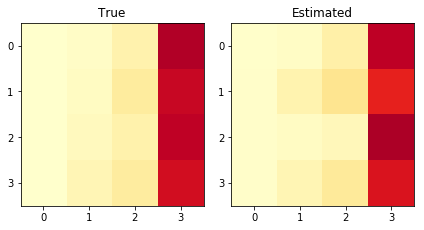

JS divergence: 0.0100	Norm Frobenius: 0.0372


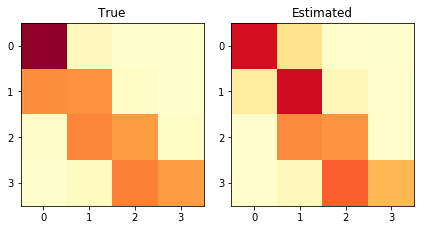

JS divergence: 0.0462	Norm Frobenius: 0.1382


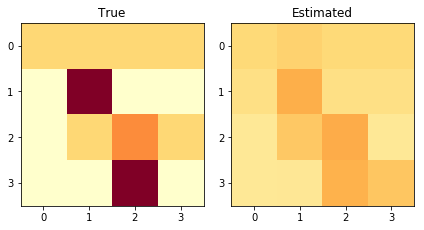

JS divergence: 0.2300	Norm Frobenius: 0.2608


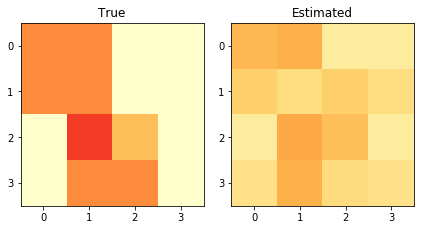

JS divergence: 0.2123	Norm Frobenius: 0.1917


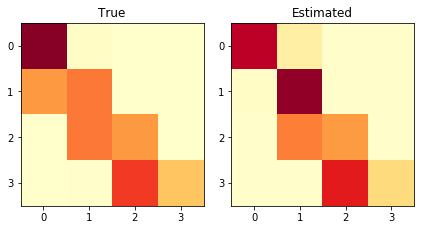

JS divergence: 0.0730	Norm Frobenius: 0.1589


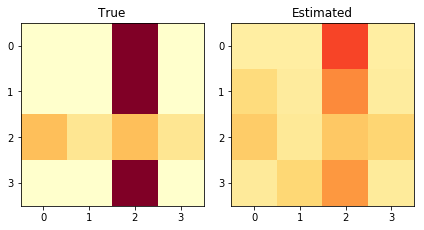

JS divergence: 0.2149	Norm Frobenius: 0.2371


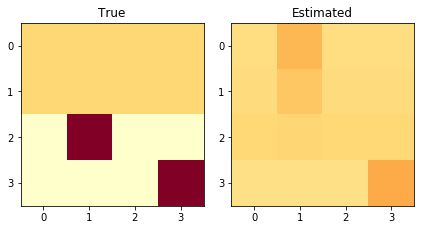

JS divergence: 0.2379	Norm Frobenius: 0.2784


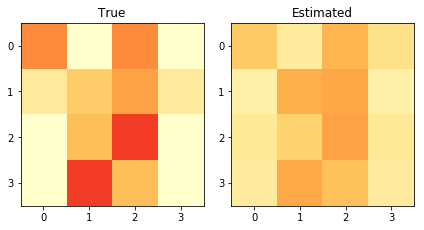

JS divergence: 0.1337	Norm Frobenius: 0.1464


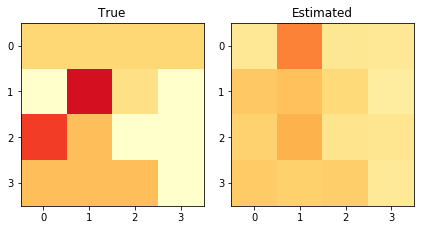

JS divergence: 0.1659	Norm Frobenius: 0.2061


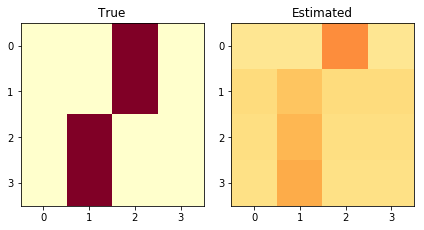

JS divergence: 0.4307	Norm Frobenius: 0.3685


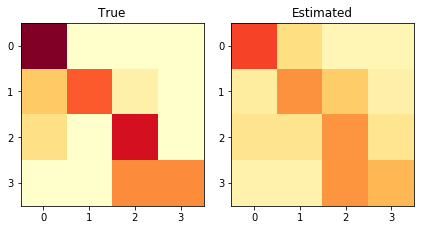

JS divergence: 0.1552	Norm Frobenius: 0.1720


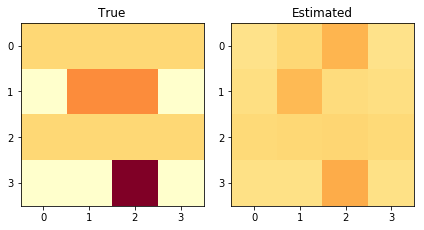

JS divergence: 0.1685	Norm Frobenius: 0.2087


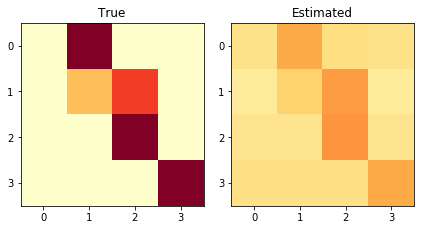

JS divergence: 0.3213	Norm Frobenius: 0.2987


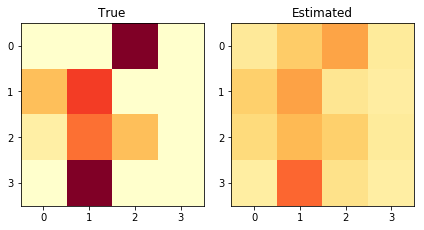

JS divergence: 0.2254	Norm Frobenius: 0.2357
Calculate confusion matrix on global version


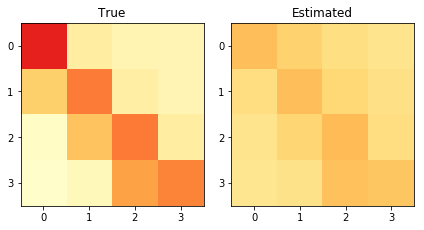

JS divergence: 0.0948	Norm Frobenius: 0.1706
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All    0.3925      0.3925      0.3535          0.2223       0.1957   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0       0.1358    0.0749     0.1706  0.0948     0.1505  0.1394

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.6878              1.0778                   0.6353   

   Cross entropy wmean  
0               0.9587

Test
A result


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy  F1 (micro)  F1 (macro)
0  All    0.2335      0.2335      0.1998

In [25]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(X_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


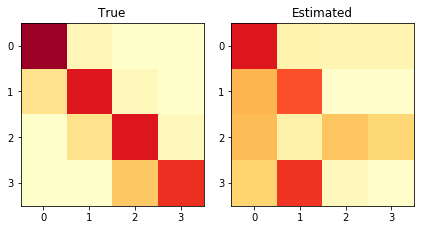

JS divergence: 0.3266	Norm Frobenius: 0.3120
Groups probabilities:  [0. 0. 1.]


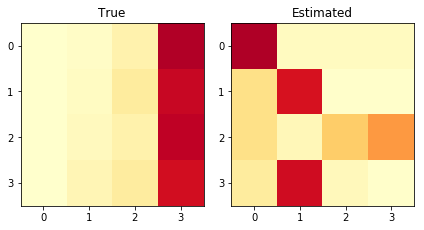

JS divergence: 0.6521	Norm Frobenius: 0.5224
Groups probabilities:  [0. 1. 0.]


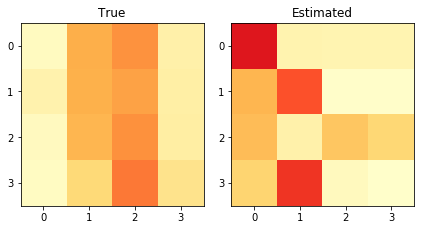

JS divergence: 0.3522	Norm Frobenius: 0.3405
Groups probabilities:  [0. 0. 1.]


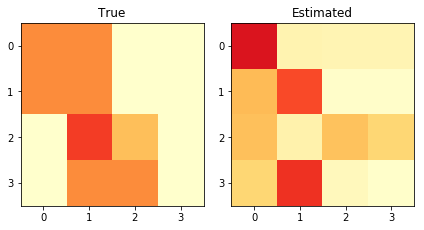

JS divergence: 0.2541	Norm Frobenius: 0.2646
Groups probabilities:  [0.03 0.05 0.92]


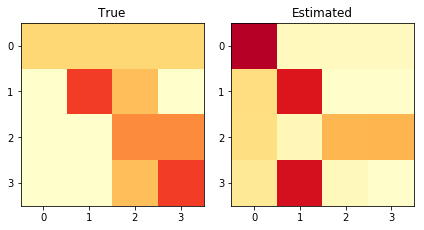

JS divergence: 0.3998	Norm Frobenius: 0.3494
Groups probabilities:  [0.18 0.65 0.17]


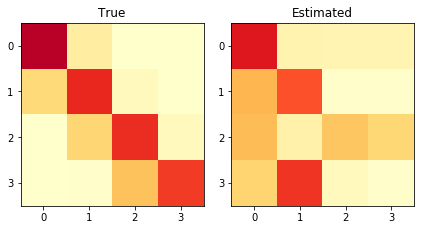

JS divergence: 0.3154	Norm Frobenius: 0.2999
Groups probabilities:  [0. 0. 1.]


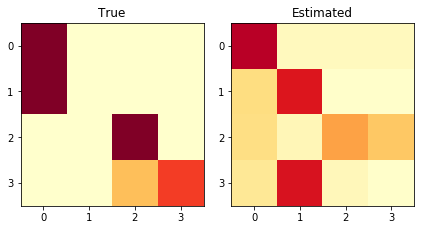

JS divergence: 0.4727	Norm Frobenius: 0.4225
Groups probabilities:  [0.35 0.43 0.22]


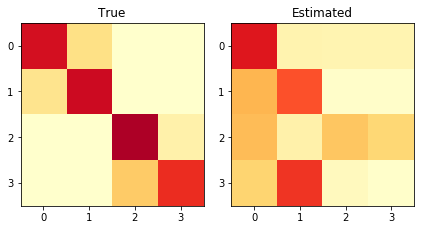

JS divergence: 0.3432	Norm Frobenius: 0.3259
Groups probabilities:  [0. 0. 1.]


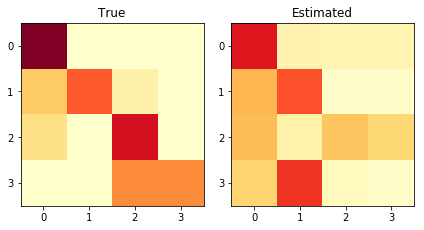

JS divergence: 0.3246	Norm Frobenius: 0.2969
Groups probabilities:  [0. 0. 1.]


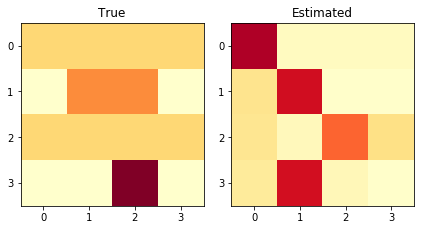

JS divergence: 0.4106	Norm Frobenius: 0.4067
Groups probabilities:  [0.73 0.14 0.13]


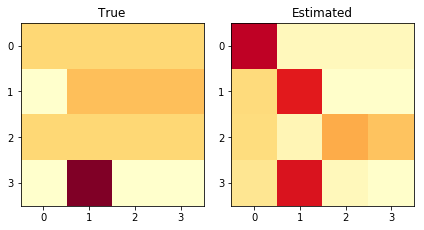

JS divergence: 0.2373	Norm Frobenius: 0.2612
Groups probabilities:  [0.25 0.45 0.3 ]


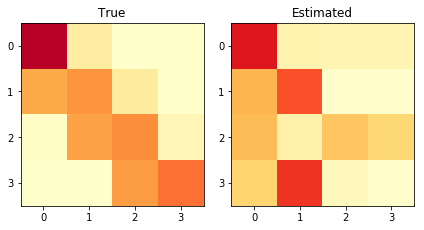

JS divergence: 0.3190	Norm Frobenius: 0.2906
Groups probabilities:  [0. 0. 1.]


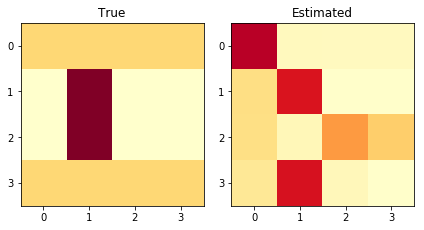

JS divergence: 0.3886	Norm Frobenius: 0.3745
Groups probabilities:  [0.41 0.38 0.21]


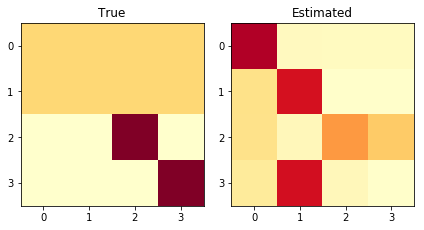

JS divergence: 0.4960	Norm Frobenius: 0.4363
Groups probabilities:  [0.43 0.45 0.12]


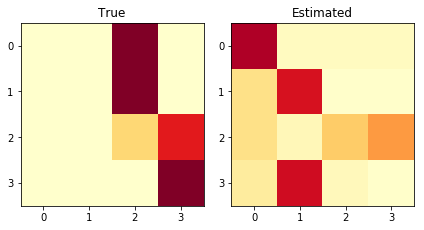

JS divergence: 0.7480	Norm Frobenius: 0.5702
Groups probabilities:  [0. 1. 0.]
Calculate confusion matrix on global version


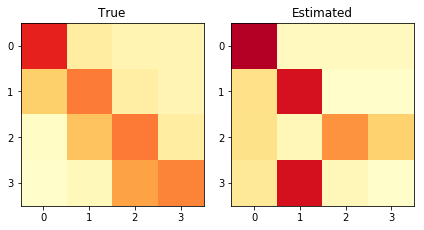

JS divergence: 0.2433	Norm Frobenius: 0.2767
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All    0.3618      0.3618      0.1397          0.3807       0.4127   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0       0.3281    0.3568     0.2767  0.2433     0.3049  0.4155

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.3639              1.4308                   0.2681   

   Cross entropy wmean  
0               1.5011

Test


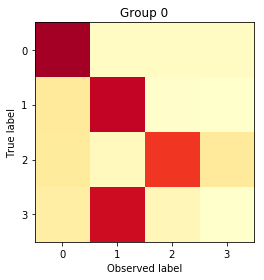

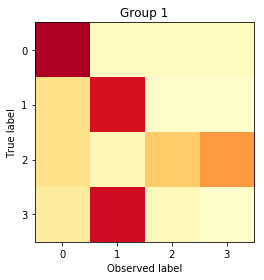

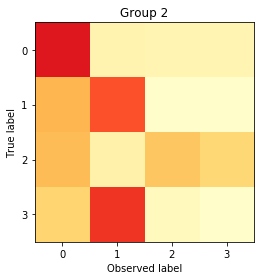

Inertia JS: 0.03884622187534514
Inertia NormF: 0.12945049976315168
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.4745    64   0.5895     0.6144     0.6793    0.4859  0.1713   
1       1  0.3603    48   0.7002     0.4969     0.5893    0.3293  0.1828   
2       2  0.1652    22   0.9122     0.4246     0.5485    0.2328  0.1934   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.0388      0.1295    0.3925      0.3925  
1       1   0.0388      0.1295    0.2092      0.2092  
2       0   0.0388      0.1295    0.1106      0.1106

A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.3922      0.3922       0.142

In [33]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs (Uniform priors) ***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual2 multiples runs***
Train
Calculate confusion matrix on repeat version


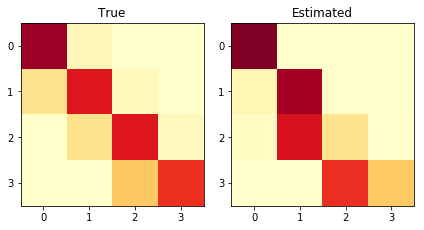

JS divergence: 0.1237	Norm Frobenius: 0.2599
Groups probabilities:  [0. 0. 1.]


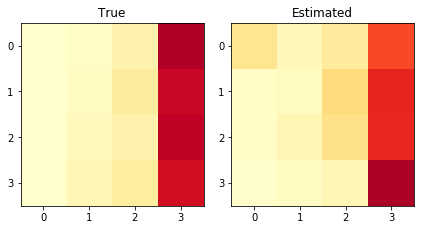

JS divergence: 0.0456	Norm Frobenius: 0.1031
Groups probabilities:  [0. 1. 0.]


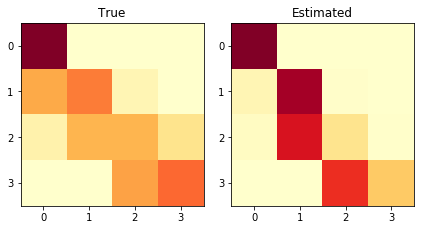

JS divergence: 0.0949	Norm Frobenius: 0.2036
Groups probabilities:  [0. 0. 1.]


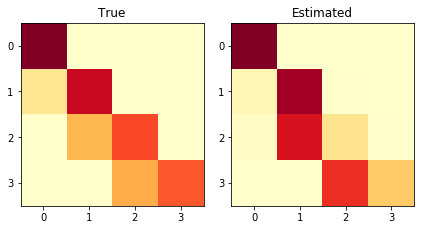

JS divergence: 0.0684	Norm Frobenius: 0.1944
Groups probabilities:  [0. 0. 1.]


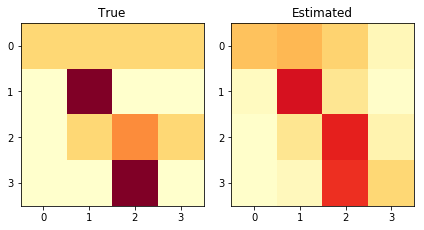

JS divergence: 0.0998	Norm Frobenius: 0.1526
Groups probabilities:  [1. 0. 0.]


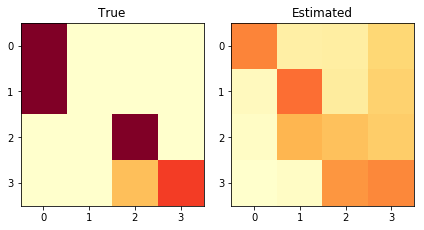

JS divergence: 0.4168	Norm Frobenius: 0.3838
Groups probabilities:  [0.26 0.37 0.38]


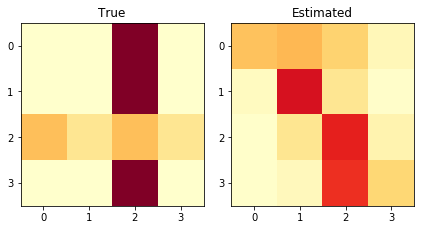

JS divergence: 0.3921	Norm Frobenius: 0.3973
Groups probabilities:  [1. 0. 0.]


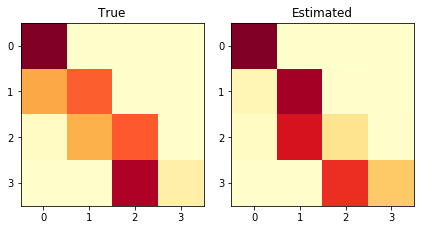

JS divergence: 0.0814	Norm Frobenius: 0.2028
Groups probabilities:  [0. 0. 1.]


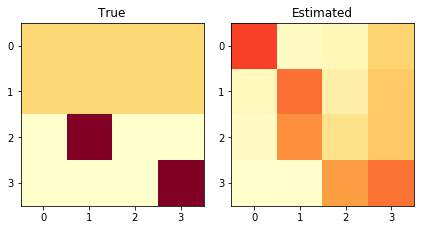

JS divergence: 0.2282	Norm Frobenius: 0.2734
Groups probabilities:  [0.   0.41 0.59]


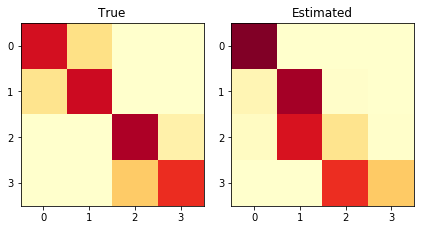

JS divergence: 0.2214	Norm Frobenius: 0.3151
Groups probabilities:  [0. 0. 1.]


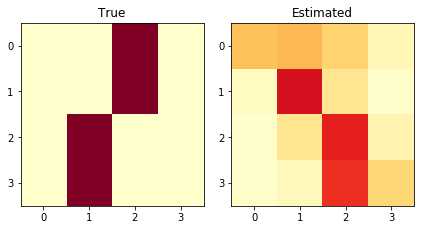

JS divergence: 0.6745	Norm Frobenius: 0.5471
Groups probabilities:  [1. 0. 0.]


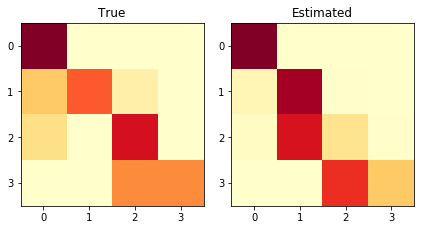

JS divergence: 0.1878	Norm Frobenius: 0.2835
Groups probabilities:  [0. 0. 1.]


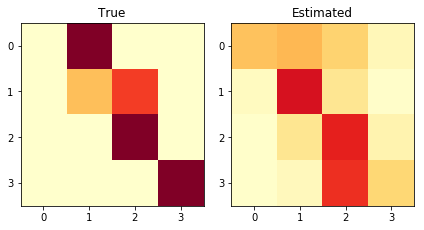

JS divergence: 0.3354	Norm Frobenius: 0.3720
Groups probabilities:  [1. 0. 0.]


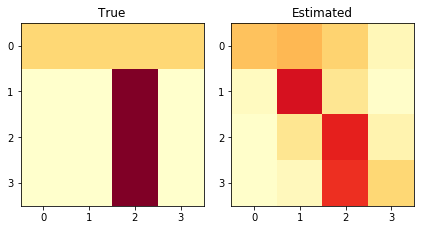

JS divergence: 0.2583	Norm Frobenius: 0.3202
Groups probabilities:  [1. 0. 0.]


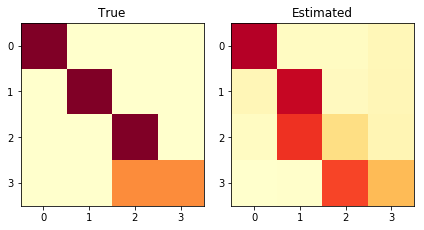

JS divergence: 0.1896	Norm Frobenius: 0.2743
Groups probabilities:  [0.06 0.08 0.86]
Calculate confusion matrix on global version


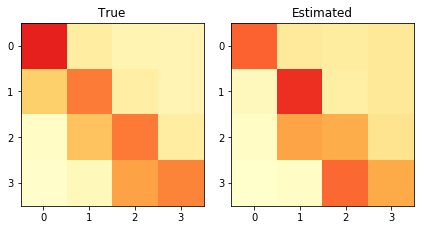

JS divergence: 0.0358	Norm Frobenius: 0.1095
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All    0.4059      0.4059      0.3662          0.3005       0.2666   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0       0.2176    0.1163     0.1095  0.0358      0.187  0.1491

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.5719              0.9818                   0.6311   

   Cross entropy wmean  
0               0.8547

Test


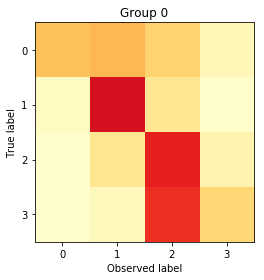

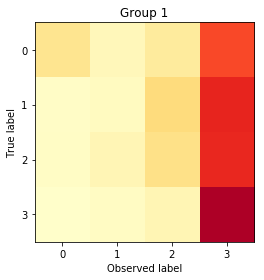

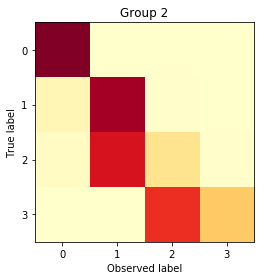

Inertia JS: 0.41381460865917274
Inertia NormF: 0.4170598061593093
A result


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.3695    49   0.8581     0.5252     0.6806    0.3669  0.2462   
1       1  0.1993    26   0.7423     0.3268     0.4492    0.1025  0.6412   
2       2  0.4312    58   0.3988     0.5981     0.7054    0.4642  0.1815   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       2   0.4138      0.4171    0.4293      0.4293  
1       3   0.4138      0.4171    0.2101      0.2101  
2       1   0.4138      0.4171    0.4142      0.4142

A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.3187      0.3187      0.2933

In [40]:
evaluate = Evaluation_metrics(gMixture_Ind2,'our1') 
aux = gMixture_Ind2.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind2.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual2 multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind2.get_confusionM()
y_o_groups = gMixture_Ind2.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individua3l multiples runs***
Train
Calculate confusion matrix on repeat version


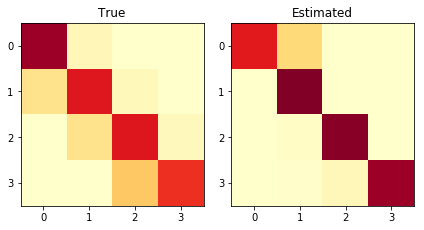

JS divergence: 0.0848	Norm Frobenius: 0.1484
Groups probabilities:  [0. 0. 1.]


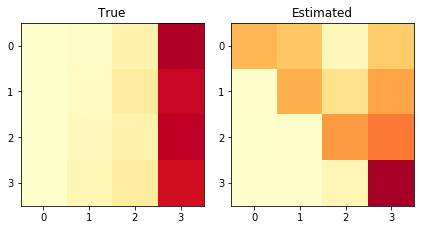

JS divergence: 0.1905	Norm Frobenius: 0.2666
Groups probabilities:  [1. 0. 0.]


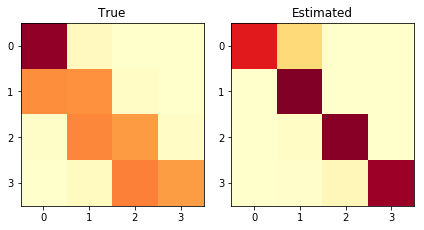

JS divergence: 0.2280	Norm Frobenius: 0.3149
Groups probabilities:  [0. 0. 1.]


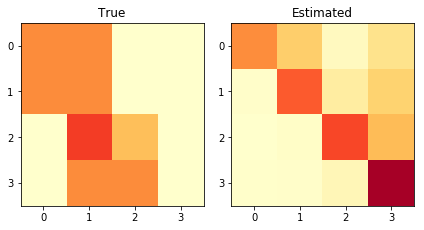

JS divergence: 0.4694	Norm Frobenius: 0.3825
Groups probabilities:  [0.63 0.01 0.36]


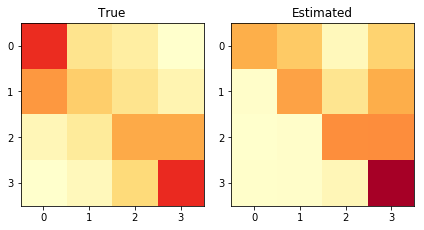

JS divergence: 0.1571	Norm Frobenius: 0.1985
Groups probabilities:  [0.92 0.   0.08]


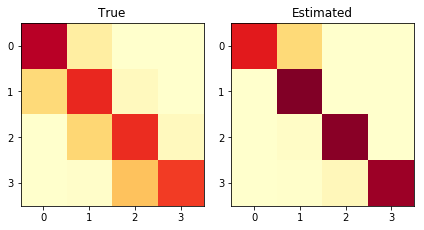

JS divergence: 0.0949	Norm Frobenius: 0.1665
Groups probabilities:  [0. 0. 1.]


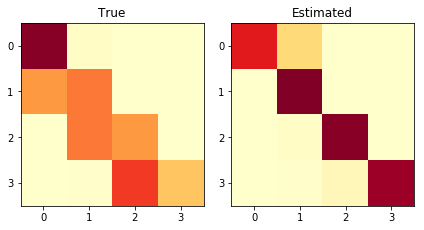

JS divergence: 0.2520	Norm Frobenius: 0.3393
Groups probabilities:  [0. 0. 1.]


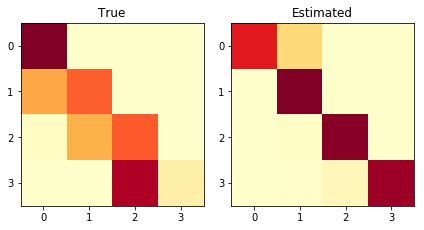

JS divergence: 0.2936	Norm Frobenius: 0.3661
Groups probabilities:  [0. 0. 1.]


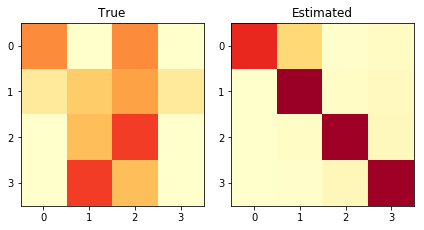

JS divergence: 0.4464	Norm Frobenius: 0.3988
Groups probabilities:  [0.08 0.   0.92]


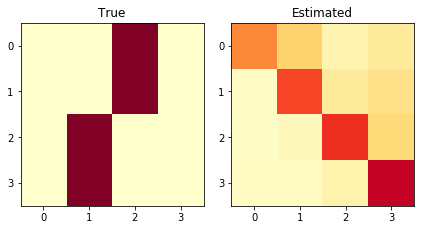

JS divergence: 0.8150	Norm Frobenius: 0.5883
Groups probabilities:  [0.41 0.13 0.45]


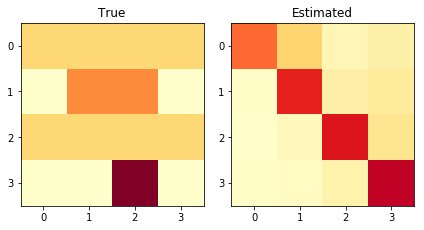

JS divergence: 0.3363	Norm Frobenius: 0.3824
Groups probabilities:  [0.28 0.12 0.59]


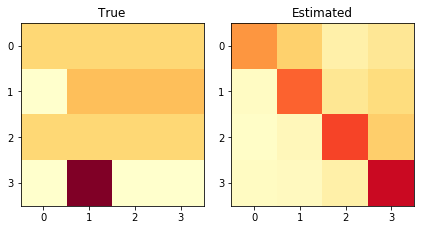

JS divergence: 0.3042	Norm Frobenius: 0.3595
Groups probabilities:  [0.47 0.17 0.36]


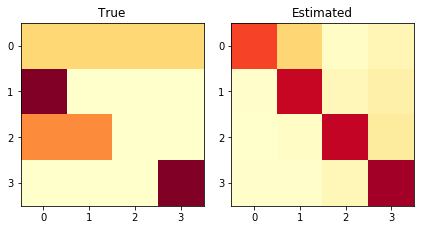

JS divergence: 0.5331	Norm Frobenius: 0.4460
Groups probabilities:  [0.23 0.01 0.75]


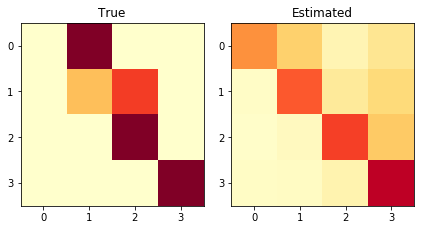

JS divergence: 0.2682	Norm Frobenius: 0.2990
Groups probabilities:  [0.52 0.1  0.38]


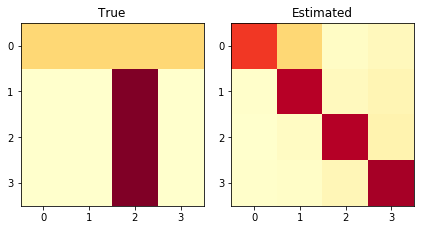

JS divergence: 0.4931	Norm Frobenius: 0.4828
Groups probabilities:  [0.14 0.03 0.83]
Calculate confusion matrix on global version


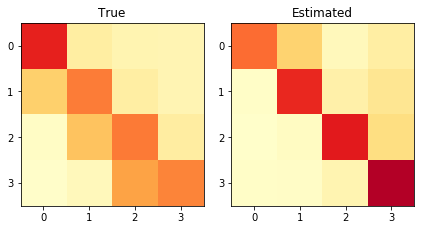

JS divergence: 0.1077	Norm Frobenius: 0.1883
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All    0.4426      0.4426      0.4355          0.3483       0.3412   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0       0.2694    0.2165     0.1883  0.1077     0.2264  0.1413

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.5207              1.0934                   0.5853   

   Cross entropy wmean  
0               0.9647

Test


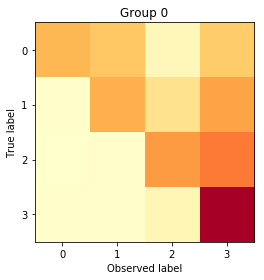

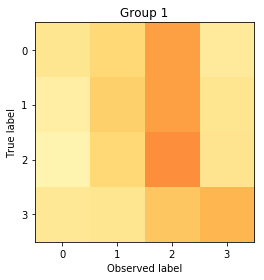

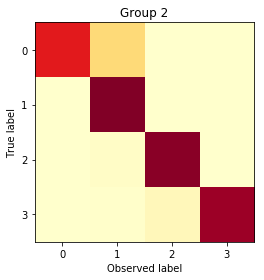

Inertia JS: 0.26712114396670866
Inertia NormF: 0.3001298243406036
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.3689    49   0.8544     0.5268     0.6892    0.3691  0.3595   
1       1  0.0701     9   1.2714     0.3268     0.5227    0.1024  0.1938   
2       2  0.5610    75   0.2460     0.9163     0.9548    0.8884  0.0689   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       3   0.2671      0.3001    0.2109      0.2109  
1       2   0.2671      0.3001    0.3934      0.3934  
2       1   0.2671      0.3001    0.3475      0.3475

A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.2417      0.2417      0.2338

In [45]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [46]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_I3 = flatten_conf(gMixture_Ind3.get_confusionM())

from sklearn.decomposition import PCA
model = PCA(2)

to_plot = model.fit_transform(to_plot)
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_I3 = model.transform(centroids_plot_I3)

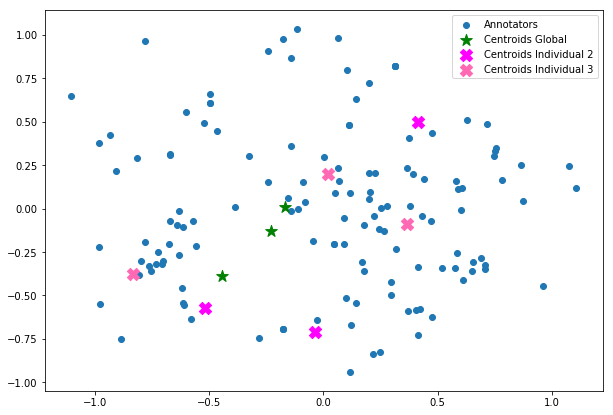

In [47]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Centroids Global")
plt.scatter(centroids_plot_I2[:,0], centroids_plot_I2[:,1],s=150, marker="X", color='magenta',label="Centroids Individual 2")
plt.scatter(centroids_plot_I3[:,0], centroids_plot_I3[:,1], s=150, marker="X", color='hotpink',label="Centroids Individual 3")

plt.legend()
plt.show()